In [2]:
from pytc2.sistemas_lineales import plot_plantilla
import sympy as sp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio

def vertical_flaten(a):

    return a.reshape(a.shape[0],1)


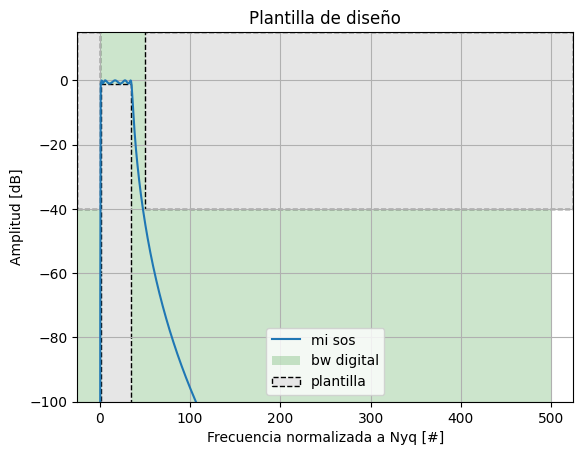

C:\Users\greta\AppData\Local\Temp\ipykernel_26196\50804100.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


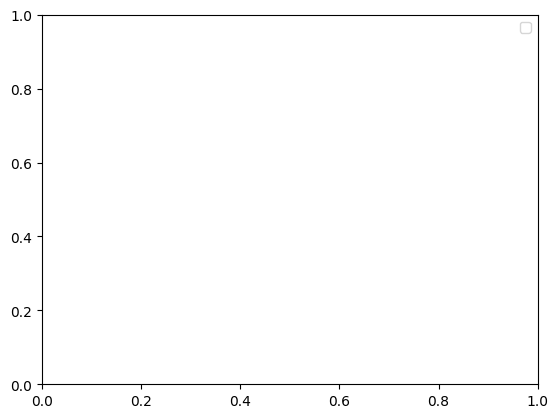

In [ ]:
fs = 1000
fpass = np.array([1,35]) #40% y 60% de la frecuencia de nyquist
ripple = 1
fstop = np.array([0.1,50.0])
attenuation = 40

sos_filter = sig.iirdesign(fpass, fstop, ripple, attenuation, ftype='cheby1', output='sos',fs=fs)


fig = plt.figure(1)
plt.cla()



#concatenamos espacios logaritmicos armamos una nueva grilla de puntos
w_rad = np.append(np.logspace(-2,0.8,250),np.logspace(0.9,1.6,250))
w_rad = np.append(w_rad,np.linspace(40, fs/2,500,endpoint=True))/fs/2*np.pi
npoints = 1000
# w, hh = sig.sosfreqz(sos_filter, worN=w_rad)
w, hh = sig.sosfreqz(sos_filter, worN=npoints)
plt.plot(w/np.pi*fs/2, 20*np.log10(np.abs(hh)+1e-15), label='mi sos')


plt.title('Plantilla de diseño')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

ax = plt.gca()

plot_plantilla(filter_type = 'bandpass' , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)
plt.legend()
plt.show()

Tamaño de la señal ECG: (1129116,)
Número de muestras: 1129116
Tamaño de la señal ECG filtrada: (1129116,)


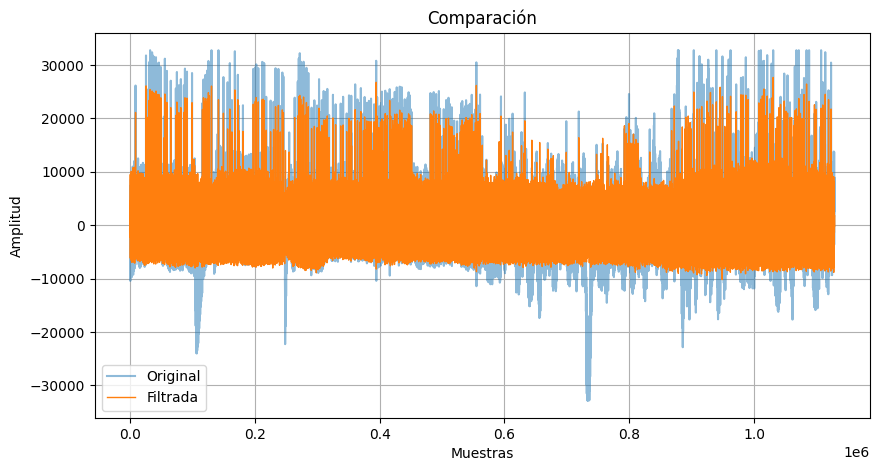

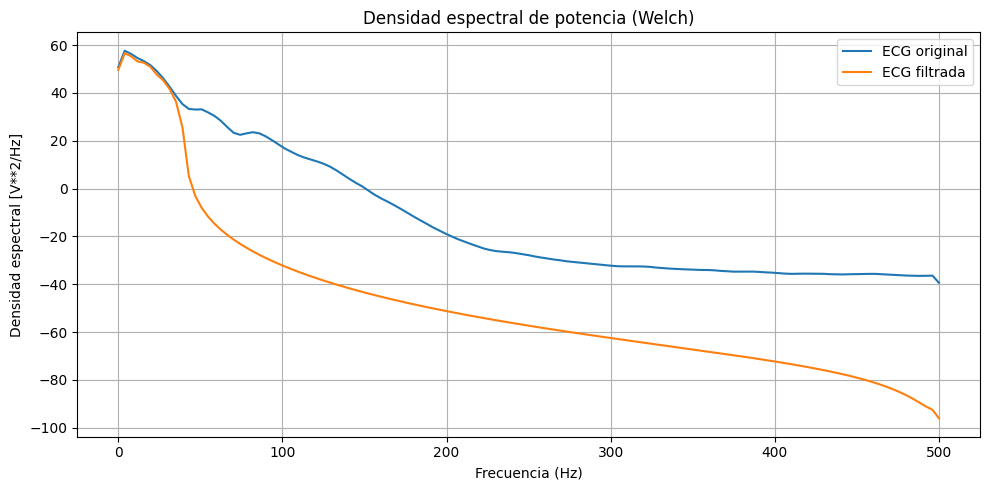

In [4]:
%matplotlib inline
# Cargar la señal ECG
fs_ecg = 1000 # Hz

# para listar las variables que hay en el archivo
sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

ecg = mat_struct['ecg_lead'].flatten()
print('Tamaño de la señal ECG:', ecg.shape)
N = len(ecg)
print('Número de muestras:', N)

# Aplicar el filtro pasa banda sin desfase
ecg_filtrada = sig.sosfiltfilt(sos_filter, ecg)
print('Tamaño de la señal ECG filtrada:', ecg_filtrada.shape)

plt.figure(figsize=(10,5))
plt.plot(ecg.ravel(), label='Original', alpha=0.5)
plt.plot(ecg_filtrada.ravel(), label='Filtrada', linewidth=1)
plt.title('Comparación')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Calcular la PSD con Welch para la señal original
ff_wel_ecg, wel_ecg = sig.welch(
    ecg, fs=fs_ecg, window='hann', nperseg=None, noverlap=None, nfft=None,
    detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean'
)

# Calcular la PSD para la señal filtrada
ff_wel_ecg_filt, wel_ecg_filt = sig.welch(
    ecg_filtrada, fs=fs_ecg, window='hann', nperseg=None, noverlap=None, nfft=None,
    detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean'
)

# Graficar comparación
plt.figure(figsize=(10,5))
plt.plot(ff_wel_ecg, 10 * np.log10(wel_ecg), label='ECG original')
plt.plot(ff_wel_ecg_filt, 10 * np.log10(wel_ecg_filt), label='ECG filtrada')
plt.title('Densidad espectral de potencia (Welch)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad espectral [V**2/Hz]')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

ecg_one_lead = ecg

## respuesta de fase del filtro

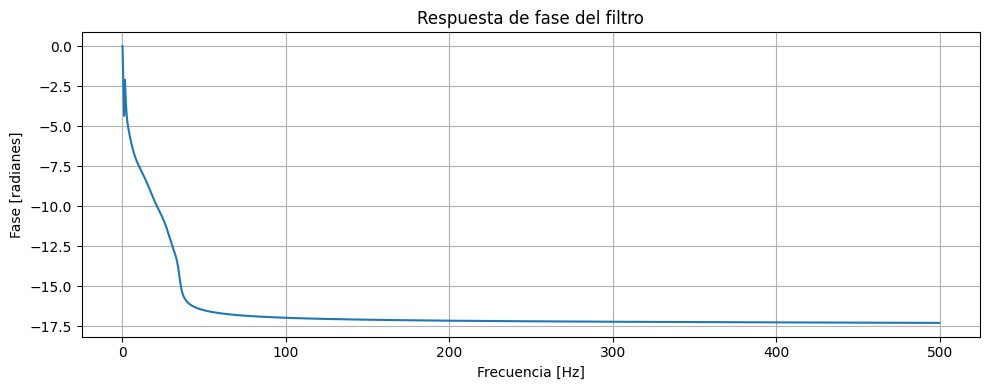

In [5]:
from scipy.signal import sosfreqz
import matplotlib.pyplot as plt
import numpy as np

# Calcula la respuesta en frecuencia
w, h = sosfreqz(sos_filter, worN=1000, fs=fs)

# Calcula la fase en radianes y la desenrolla
fase = np.angle(h)
fase = np.unwrap(fase)

plt.figure(figsize=(10, 4))
plt.plot(w, fase)
plt.title('Respuesta de fase del filtro')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [radianes]')
plt.grid(True)
plt.tight_layout()
plt.show()

#### CALCULAR EL RETARDO CON UN FILTRO FIR ####
### OTRA FORMA DE ESTIMARLO A OJIMETRO ES MIRAR LA DEMORA DEL FILTRO FILT A SECAS Y VER LA DIFERENCIA ENTRE LOS PICOS
### 


cada singularidad tiene tiene pi/2 de desembolvimiento de fase, y aca si la matriz sos tieene 15 filas, entobces tiene 30 singularidades.

## respuesta de modulo del filtro

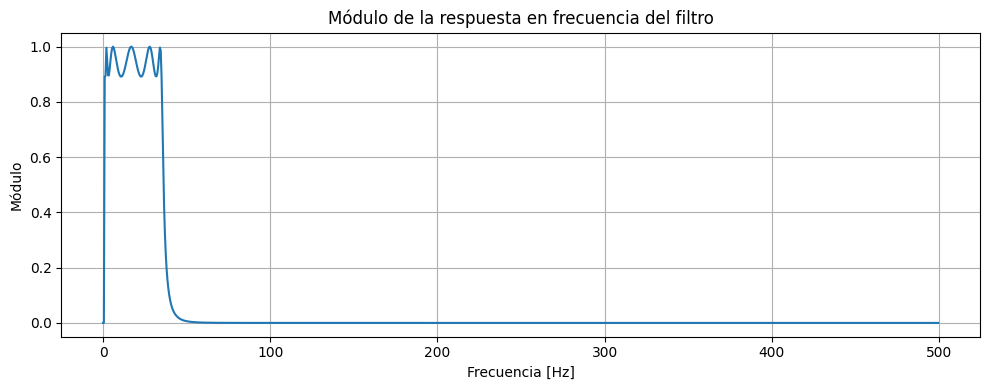

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(w, np.abs(h))
plt.title('Módulo de la respuesta en frecuencia del filtro')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo')
plt.grid(True)
plt.tight_layout()
plt.show()


para calcular la demora, debo calcular la derivada de la respuesta de fase :)
- usar diff que calcula la diferencia entre muestras adyacentes. Si usas el omega ccon el linespace log hay q calcularlo para omega y para y.


In [7]:
%matplotlib qt
cant_muestras = ecg_one_lead.shape[0]
fig_sz_x = 10
fig_sz_y = 5
fig_dpi = 100
demora = 0
ECG_f_win = ecg_filtrada
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()